In [2]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [3]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [4]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine', 'inverse_l1'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        embedding_trainable=True)

Number of inputs to dense layer: 17


# Train model 

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 20s 45us/step - loss: 1.8025e-04 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 0.9990


# Learning curves

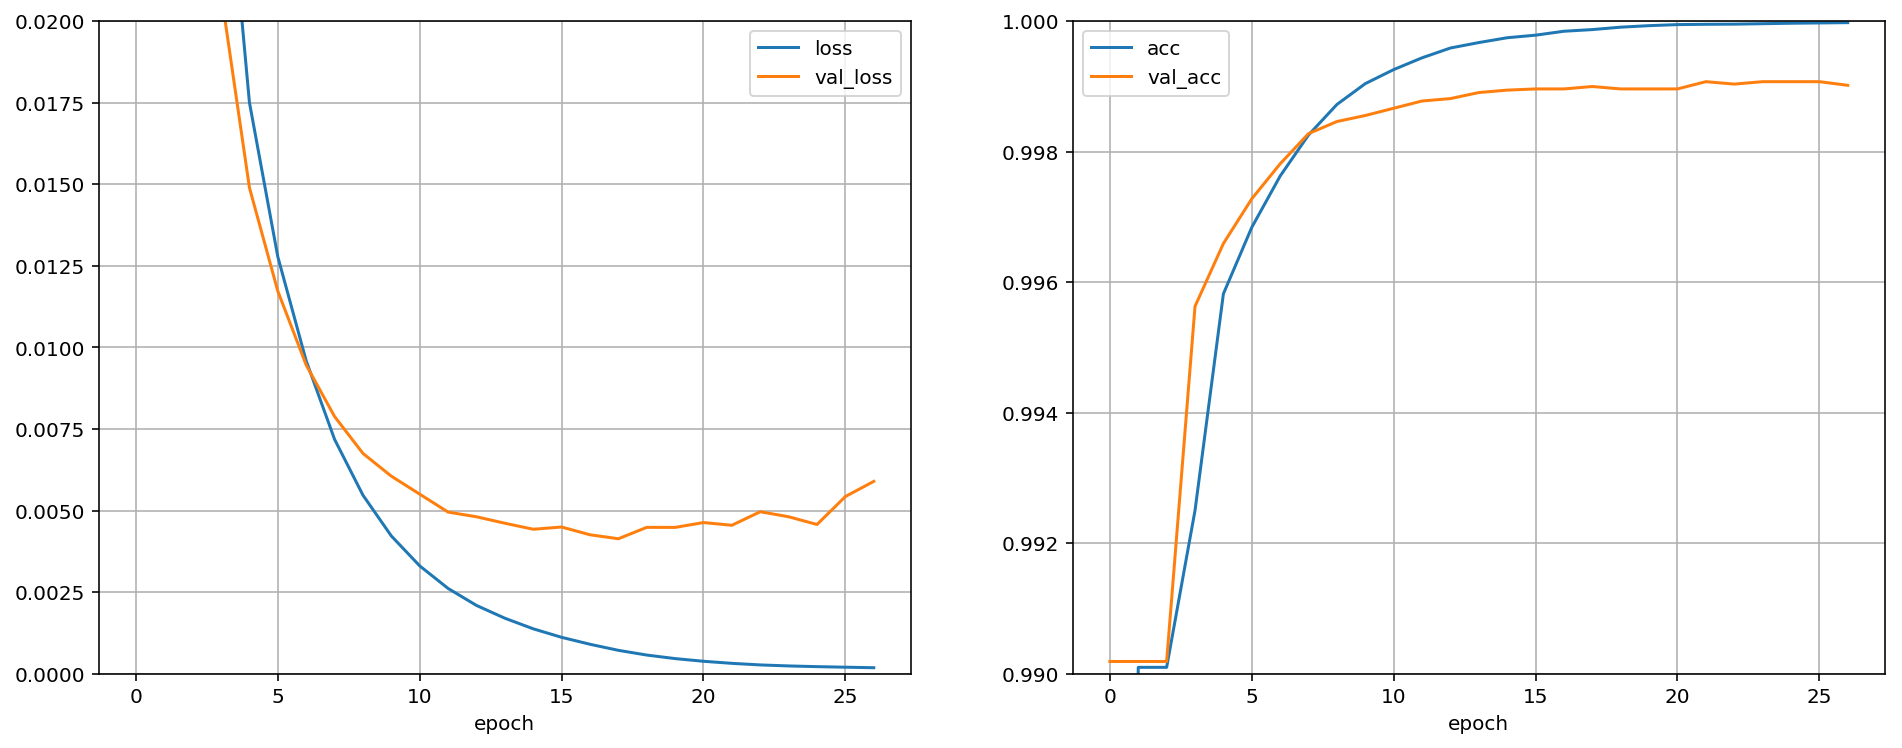

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [19]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.99      0.91      0.95       530

avg / total       1.00      1.00      1.00     54004

[[53469     5]
 [   47   483]]


In [20]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine

,id1,title,authors,venue,year,id2,title,authors,venue,year
182,conf/sigmod/ParkCY95,an effective hash based algorithm for mining association rules,park chen yu,sigmod conference,1995,x5By8kBxxpwJ,an effective algorithm forming association rules,js park ms chen ps yu,proceedings of the 1995 acm sigmod international conference,0.0
1026,conf/vldb/AgrawalS94,fast algorithms for mining association rules in large databases,agrawal srikant,vldb,1994,3MzTom30SiMJ,fastalgorithmsformining association rules,rar srikant,of the vldb conference santiago chile september,0.0
1454,conf/sigmod/GodfreySE98,secure and portable database extensibility,godfrey mayr seshadri eicken,sigmod conference,1998,-H3tXntLhowJ,secure andportabledatabaseextensibility,godfrey mayr seshadri von eicken,acm sigmod,0.0
2019,journals/sigmod/Wu02,small worlds the dynamics of networks between order and randomness book review,nan,nan,2002,zCrDiwnKRHIJ,small worlds the dynamics of networks between order and randomness,dj watts,nan,1999.0
3788,conf/sigmod/RoussopoulosKV95,nearest neighbor queries,roussopoulos kelley vincent,sigmod conference,1995,y8Sm4Sh4hokJ,vincent nearest neighbor,rossopoulos kelly,of pages,0.0
5680,conf/sigmod/MaddenSHR02,continuously adaptive continuous queries over streams,madden shah hellerstein raman,sigmod conference,2002,WhBHQqg-7l8J,continuously adaptive continuous queries,sm ms02 shah jm hellerstein raman,nan,2000.0
7848,conf/sigmod/BettiniWBJ95,semantic assumptions and query evaluation in temporal databases,bettini wang bertino jajodia,sigmod conference,1995,wZkNJJn90yAJ,jajodia semanticassumptionsandqueryevaluation in temporal databases,bettini wang bertino,of acm sigmod san jose ca,0.0
8685,conf/sigmod/AnkerstBKS99,optics ordering points to identify the clustering structure,ankerst breunig kriegel sander,sigmod conference,1999,rgEDmTFPFY4J,ordering points to identify the clustering structure proc,ankerst mm breunig hp kriegel js optics,acm,0.0
11286,conf/vldb/ManegoldBK00,what happens during join dissecting cpu and memory optimization effects,manegold boncz kersten,vldb,2000,sZmrat79cF0J,what happens duringajoin dissectingcpuandmemoryoptimization effects,manegold pa boncz ml kersten,on very large data bases cairo egypt,0.0
11340,journals/vldb/PapadiasS94,qualitative representation of spatial knowledge in space,papadias sellis,vldb,1994,kEte3P_QB60J,qualitative representation ofspatial knowledge,dpt sellis,vldb journal,0.0


# Save model and histories 

In [21]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-1t-num-null-allsim.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1t-num-null-allsim')

# Test model 

In [5]:
model.load_weights('../data/models/dblp-scholar-base-1t-num-null-allsim')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99918   0.99996   0.99957     53467
          1    0.99597   0.91822   0.95551       538

avg / total    0.99915   0.99915   0.99913     54005

[[53465     2]
 [   44   494]]
